# How to score 0.11952 and get top 19%

### by Mohtadi Ben Fraj

### Credits

Part of the code for data exploration is taken for this notebook (https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn/notebook). 
The idea of averaging the models is inspired from this notebook (https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

### Importing libraries and data

In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

from xgboost.sklearn import XGBRegressor

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/home/maviator/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get home price train & test csv files as a DataFrame
train = pd.read_csv("../Data/train.csv")
test    = pd.read_csv("../Data/test.csv")
full = train.append(test, ignore_index=True)
print (train.shape, test.shape, full.shape)

((1460, 81), (1459, 80), (2919, 81))


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check for missing data

In [4]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


### Helper functions

In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

## Removing outliers

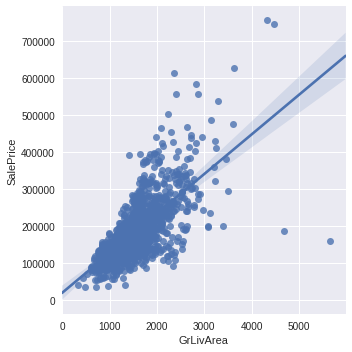

In [6]:
sns.lmplot(x='GrLivArea', y='SalePrice',  data=train)

In [7]:
train = train[train.GrLivArea < 4500]

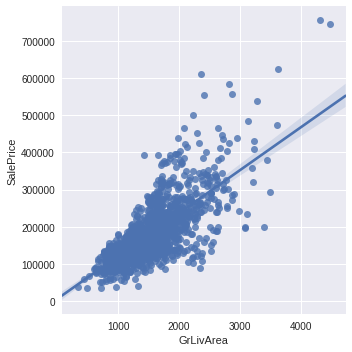

In [8]:
sns.lmplot(x='GrLivArea', y='SalePrice',  data=train)

### Splitting to features and labels and deleting variables I don't need

In [9]:
# Spliting to features and lables
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

In [10]:
# Deleting features that are more than 50% missing
features.drop(['PoolQC', 'MiscFeature', 'FireplaceQu', 'Fence', 'Alley'],
              axis=1, inplace=True)
features.shape

(2917, 75)

### Filling missing values

In [11]:
# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# MasVnrArea NA in all. filling with mean value
features['MasVnrArea'] = features['MasVnrArea'].fillna(features['MasVnrArea'].mean())

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# BsmtFinSF1 and BsmtFinSF2  NA in pred. I suppose NA means 0
features['BsmtFinSF1'] = features['BsmtFinSF1'].fillna(0)   
features['BsmtFinSF2'] = features['BsmtFinSF2'].fillna(0)  
    
# BsmtFullBath and BsmtHalfBath NA in all. filling with most popular value
features['BsmtFullBath'] = features['BsmtFullBath'].fillna(features['BsmtFullBath'].median())
features['BsmtHalfBath'] = features['BsmtHalfBath'].fillna(features['BsmtHalfBath'].median())

# BsmtUnfSF NA in all. Filling with mean value
features['BsmtUnfSF'] = features['BsmtUnfSF'].fillna(features['BsmtUnfSF'].mean())

# Exterior1st and Exterior2nd NA in all. filling with most popular value
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

# Functional NA in all. filling with most popular value
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0])

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# GarageArea NA in all. NA means no garage so 0
features['GarageArea'] = features['GarageArea'].fillna(0.0)

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageQual', 'GarageCond'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Utilities NA in all. filling with most popular value
features['Utilities'] = features['Utilities'].fillna(features['Utilities'].mode()[0])

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt'], axis=1, inplace=True)

In [12]:
features.shape

(2917, 72)

### Log transformation

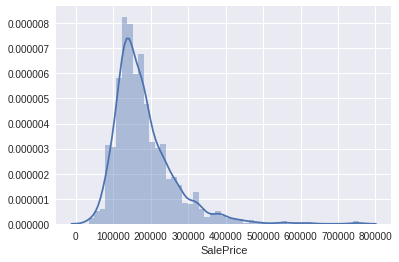

In [13]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [14]:
## Log transformation of labels
train_labels = np.log(train_labels)

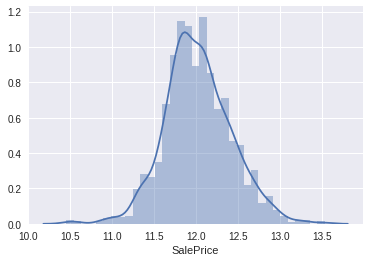

In [15]:
## Now it looks much better
ax = sns.distplot(train_labels)

## Converting categorical features with order to numerical

# Converting categorical variables with choices: Ex, Gd, TA, FA and Po
def cat2numCondition(x):
    if x == 'Ex':
        return 5
    if x == 'Gd':
        return 4
    if x == 'TA':
        return 3
    if x == 'Fa':
        return 2
    if x == 'Po':
        return 1
    return -1

features.shape
cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
        'KitchenQual', 'GarageQual', 'GarageCond']
for col in cols:
    features[col+'_num'] = features[col].apply(cat2numCondition)
    features.pop(col)
features.shape

# Converting categorical condition: Gd, Av, Mn, No
def cat2numBsmnt(x):
    if x == 'Gd':
        return 3
    if x == 'Av':
        return 2
    if x == 'Mn':
        return 1
    if x == 'No':
        return 0
    return -1

features['BsmtExposure_num'] = features['BsmtExposure'].apply(cat2numBsmnt)
features.pop('BsmtExposure')
features.shape

# Converting categorical values: GLQ, ALQ, BLQ, Rec, LwQ, Unf
''''
def cat2numQual(x):
    if x == 'GLQ':
        return 5
    if x == 'ALQ':
        return 4
    if x == 'BLQ':
        return 3
    if x == 'Rec':
        return 2
    if x == 'LwQ':
        return 1
    if x == 'Unf':
        return 0
    return -1
    ''''

cols = ['BsmtFinType1', 'BsmtFinType2']
for col in cols:
    features[col+'_num'] = features[col].apply(cat2numCondition)
    features.pop(col)
features.shape

In [16]:
def num2cat(x):
    return str(x)

In [17]:
features['MSSubClass_str'] = features['MSSubClass'].apply(num2cat)
features.pop('MSSubClass')
features.shape

(2917, 72)

### Converting categorical features to binary

In [18]:
# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [19]:
features.shape

(2917, 291)

In [20]:
features.head()

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
train 0   1         65.0     8450            7            5       2003   
      1   2         80.0     9600            6            8       1976   
      2   3         68.0    11250            7            5       2001   
      3   4         60.0     9550            7            5       1915   
      4   5         84.0    14260            8            5       2000   

         YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2        ...          \
train 0          2003       196.0       706.0         0.0        ...           
      1          1976         0.0       978.0         0.0        ...           
      2          2002       162.0       486.0         0.0        ...           
      3          1970         0.0       216.0         0.0        ...           
      4          2000       350.0       655.0         0.0        ...           

         MSSubClass_str_30  MSSubClass_str_40  MSSubClass_str_45  \
train 0                  0                  0                  0   
      1                  0                  0                  0   
      2                  0                  0                  0   
      3                  0                  0                  0   
      4                  0                  0                  0   

         MSSubClass_str_50  MSSubClass_str_60  MSSubClass_str_70  \
train 0                  0                  1                  0   
      1                  0                  0                  0   
      2                  0                  1                  0   
      3                  0                  0                  1   
      4                  0                  1                  0   

         MSSubClass_str_75  MSSubClass_str_80  MSSubClass_str_85  \
train 0                  0                  0                  0   
      1                  0                  0                  0   
      2                  0                  0                  0   
      3                  0                  0                  0   
      4                  0                  0                  0   

         MSSubClass_str_90  
train 0                  0  
      1                  0  
      2                  0  
      3                  0  
      4                  0  

[5 rows x 291 columns]

## Overfitting columns

In [21]:
#features.drop('MSZoning_C (all)',axis=1)

### Splitting train and test features

In [22]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting to train and validation sets

In [23]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features,
                                                    train_labels,
                                                    test_size=0.1,
                                                    random_state=200)

### Modeling

#### 1. Gradient Boosting Regressor

In [24]:
GBR = GradientBoostingRegressor(n_estimators=12000,
            learning_rate=0.05, max_depth=3, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10, loss='huber')

In [25]:
GBR.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=12000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [26]:
train_test(GBR, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=15,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=12000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
R2: 0.986593919341
RMSE: 0.0453551396433
Test
R2: 0.926366183768
RMSE: 0.0971768543418


In [27]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBR, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.01)


#### 2. LASSO regression

In [28]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [29]:
lasso.fit(x_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [30]:
train_test(lasso, x_train, x_test, y_train, y_test)

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])
R2: 0.932724224129
RMSE: 0.0998841007389
Test
R2: 0.928964733122
RMSE: 0.094215052758


In [31]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(lasso, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.01)


#### 3. Elastic Net Regression

In [32]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [33]:
ENet.fit(x_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [34]:
train_test(ENet, x_train, x_test, y_train, y_test)

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])
R2: 0.933899048998
RMSE: 0.099090537342
Test
R2: 0.928796805614
RMSE: 0.0944458462048


In [35]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(ENet, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.01)


### Averaging models

In [36]:
# Retraining models on all train data
GBR.fit(train_features, train_labels)
lasso.fit(train_features, train_labels)
ENet.fit(train_features, train_labels)

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [39]:
def averaginModels(X, train, labels, models=[]):
    for model in models:
        model.fit(train, labels)
    predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)

In [40]:
test_y = averaginModels(test_features, train_features,
                        train_labels, [GBR, lasso, ENet])
test_y = np.exp(test_y)

### Submission

In [41]:
test_id = test.Id
test_submit = pd.DataFrame({'Id': test_id, 'SalePrice': test_y})
test_submit.shape
test_submit.head()
test_submit.to_csv('house_price_pred_avg_gbr_lasso_enet.csv', index=False)

### History

- Using Gradient boosting regression model: 0.12217
- Using Random Forest regression mode: 0.14146
- Weighted average of GBR and RF with .75 and .25 weights respectively produces better result: 0.12178
- Link on ensembling and stacking models: https://mlwave.com/kaggle-ensembling-guide/ 
- Averaging of 4 models: GBR, RF, lasso and ENet: error: 0.11952
- Removing outliers and averaging GBR, lasso and ENEt: error: 0.11793
- Retraining final models on all train data: error: 0.11739
- Converted MSSubClass to categorical: error: 0.11660